# Homework 6 - Assignment 1

## Authored by JKtours

### Principles of Urban Informatics 2017

### *Modification of: fbb skeleton notebook for PUI2017 HW6*

In [1]:
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
import pylab as pl
import os, shutil
import json
import requests
import statsmodels.api as sm
import statsmodels.formula.api as smf

if os.getenv("PUIDATA") is None:
    print ("$PUIDATA to point to set PUIdata dir")

%pylab inline

Populating the interactive namespace from numpy and matplotlib



** An interesting urban question is "can we measure and predict energy use based on observables that are easily acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.**

** So let's test if the last link holds. If we have data on the _energy consumed by a building_ how well does that relate to the _number of units_ in the building?**

** Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  **

** Either obtain the data through the API or download the csv file, and move it to $PUIDATA**

** However this datasets does not have the number of units. We can find that in the [Pluto dataset](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page).**

** Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp ** Note that you should keep all the files in the original MNMapPluto zipped folder (not just the .shp file) for geopandas to read the data in correctly.

In [2]:
# Sources for data
#!wget https://data.cityofnewyork.us/resource/m46j-75iy.json

!wget https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv
!mv rows.csv Energy_and_Water_Data_Disclosure_for_Local_Law_84_2013.csv
!ls -l Energy_and_Water_Data_Disclosure_for_Local_Law_84_2013.csv
os.system("mv %s %s"%("Energy_and_Water_Data_Disclosure_for_Local_Law_84_2013.csv",os.getenv("PUIDATA")))
    
!wget https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v2.zip
os.system("mv mn_mappluto_16v2.zip " + os.getenv("PUIDATA"))
os.system("unzip " + os.getenv("PUIDATA") + "/mn_mappluto_16v2.zip" + " -d " + os.getenv("PUIDATA") +"/Manhattan")


##shutil.move("mn_mappluto_16v2.zip",os.getenv("PUIDATA")+"/mn_mappluto_16v2.zip")
#os.system("unzip " + "mn_mappluto_16v2.zip" + "-d " + os.getenv("PUIDATA") +"/")
#!unzip mn_mappluto_16v2.zip 


#!touch rows.csv
#!ls -l rows.csv
#!mv rows.csv Energy_and_Water_Data_Disclosure_for_Local_Law_84_2013.csv
#!ls -l Energy_and_Water_Data_Disclosure_for_Local_Law_84_2013.csv
#!ls -l rows.csv   #no missing
#  mv <SRC_PATH>/ABC_$t1.dat <DEST_PATH>/ABC_$t1_$$.dat



--2017-11-26 15:32:36--  https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv
Resolving data.cityofnewyork.us... 52.206.140.205
Connecting to data.cityofnewyork.us|52.206.140.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: “rows.csv”

    [    <=>                                ] 4,433,512   6.43M/s   in 0.7s    

Last-modified header invalid -- time-stamp ignored.
2017-11-26 15:32:37 (6.43 MB/s) - “rows.csv” saved [4433512]

-rw-r--r--. 1 vmr286 vmr286 4433512 Nov 26 15:32 Energy_and_Water_Data_Disclosure_for_Local_Law_84_2013.csv
--2017-11-26 15:32:37--  https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v2.zip
Resolving www1.nyc.gov... 104.106.240.221, 2600:141b:13:292::1500, 2600:141b:13:297::1500
Connecting to www1.nyc.gov|104.106.240.221|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9857321 (9.4M) [application/zip]
Saving to: “mn_mappluto_16v2.zip”

1

256

In [3]:
nrg = gp.GeoDataFrame.from_csv(os.getenv("PUIDATA") + "/Energy_and_Water_Data_Disclosure_for_Local_Law_84_2013.csv")
bsize = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/Manhattan/MNMapPLUTO.shp")

In [4]:
nrg.shape, bsize.shape

((16170, 31), (42686, 88))

In [5]:
nrg.head()

,BBL,Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Postcode,DOF Benchmarking Submission Status,Site EUI(kBtu/ft2),...,DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,NTA
Record Number,,,,,,,,,,,,,,,,,,,,,
12086,1.000410e+09,NaN,1000410001,1001007,NaN,NaN,Manhattan,NaN,BBL not valid,NaN,...,NaN,Office,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14354,4.021460e+09,NaN,NaN,NaN,63-10,108 STREET,Queens,11375.0,No Submission Matched to BBL,NaN,...,82730.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12150,2.027620e+09,NaN,2027620097,2006460,NaN,NaN,Bronx,NaN,BBL not valid,NaN,...,NaN,Multifamily Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12590,1.006700e+09,NaN,NaN,NaN,201,11 AVENUE,Manhattan,10001.0,No Submission Matched to BBL,NaN,...,440360.0,NaN,1.0,40.749652,-74.006471,4.0,3.0,99.0,1012266.0,Hudson Yards-Chelsea-Flatiron-Union Square ...
15591,2.048300e+09,NaN,2048300034,2063117,NaN,NaN,Bronx,NaN,Not on Covered Buildings List,NaN,...,NaN,Multifamily Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
nrg.drop(['Co-reported BBL Status', 'BBLs Co-reported', 'DOF Benchmarking Submission Status', 
          'Weather Normalized Site EUI(kBtu/ft2)', 'Weather Normalized Source EUI(kBtu/ft2)',
          'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)','Automatic Water Benchmarking Eligible',
          'Reported Water Method', 'Total GHG Emissions(MtCO2e)', 'Direct GHG Emissions(MtCO2e)', 
          'Indirect GHG Emissions(MtCO2e)', 'Reported NYC Building Identificaiton Numbers (BINs)',
          'Street Number', 'Street Name', 'Borough', 
          'Source EUI(kBtu/ft2)', 'ENERGY STAR Score',
          'DOF Property Floor Area (Buildngs and Parking)(ft2)',
          'Primary Property Type - Self Selected', 
          'Latitude', 'Longitude', 'Community Board', 'Council District',
          'Census Tract',  'NTA', 'BIN'], axis=1, inplace=True)


In [7]:
bsize.drop(['APPBBL', 'APPDate', 'Address', #'AllZoning1', 'AllZoning2',
            'AreaSource', 'AssessLand', 'AssessTot', 'BldgArea', 'BldgClass',
            'BldgDepth', 'BldgFront', 'Block', 'BoroCode', 'Borough', 'BsmtCode',
            'BuiltFAR', 'CB2010', 'CD', 'CT2010', 'ComArea', 'CommFAR', #'BuiltCode',
            'CondoNo', 'Council', 'EDesigNum', 'Easements', 'ExemptLand',
            'ExemptTot', 'Ext', 'FacilFAR', 'FactryArea', 'FireComp', 'GarageArea',
            'HealthArea', 'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot',
            'LotArea', 'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
            'NumBldgs', 'NumFloors', 'OfficeArea', 'OtherArea', 'Overlay1',
            'Overlay2', 'OwnerName', 'OwnerType', 'PLUTOMapID', 'PolicePrct',
            'ProxCode', 'ResArea', 'ResidFAR', 'RetailArea', 'SHAPE_Area',
            'SHAPE_Leng', 'SPDist1', 'SPDist2', 'Sanborn', 'SanitBoro', u'SanitDistr', u'SPDist3', # 'SanitDist',
            'SanitSub', 'SchoolDist', 'SplitZone', 'StrgeArea', 'TaxMap',
            'Tract2010', 'Version', 'XCoord', 'YCoord',
            'YearAlter1', 'YearAlter2', 'ZMCode', 'ZipCode',
            'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'ZoneMap',
            'geometry'], axis=1, inplace=True)

In [8]:
nrg.rename(columns={'BBL': 'NYC_Borough_Block_Lot', 'Postcode' : 'ZIP_Code', 'Reported Property Floor Area (Building(s)) (ft²)' : 'Reported_Prop_Flr_Area_Building_s_ft2'}, inplace=True)

In [9]:
nrg['Site EUI(kBtu/ft2)'] = pd.to_numeric(nrg['Site EUI(kBtu/ft2)'], errors='coerce')
nrg['Reported_Prop_Flr_Area_Building_s_ft2'] = pd.to_numeric(nrg['Reported_Prop_Flr_Area_Building_s_ft2'], errors='coerce')

As we discussed, coming up with a sensible model generally requires domain expertise. However, if the data you are investigating shows "obvious patterns", for example if two of the variable look like a line when plotted one against the other, then those patterns (correlations) may help you finding reasonable models for the data.

Explore your data, starting with a scatter matrix. 
A scatter matrix is a plot of all variables in your data against all other variables: 
each pair of variables is a subplot in the plot matrix. The diagonal line then would be a plot of a variable against itself, which is useless, so it is usually substituted by a histogram of that variable (or sometimes a KDE, which is basically a smooth histogram).

## Exploratory analysis

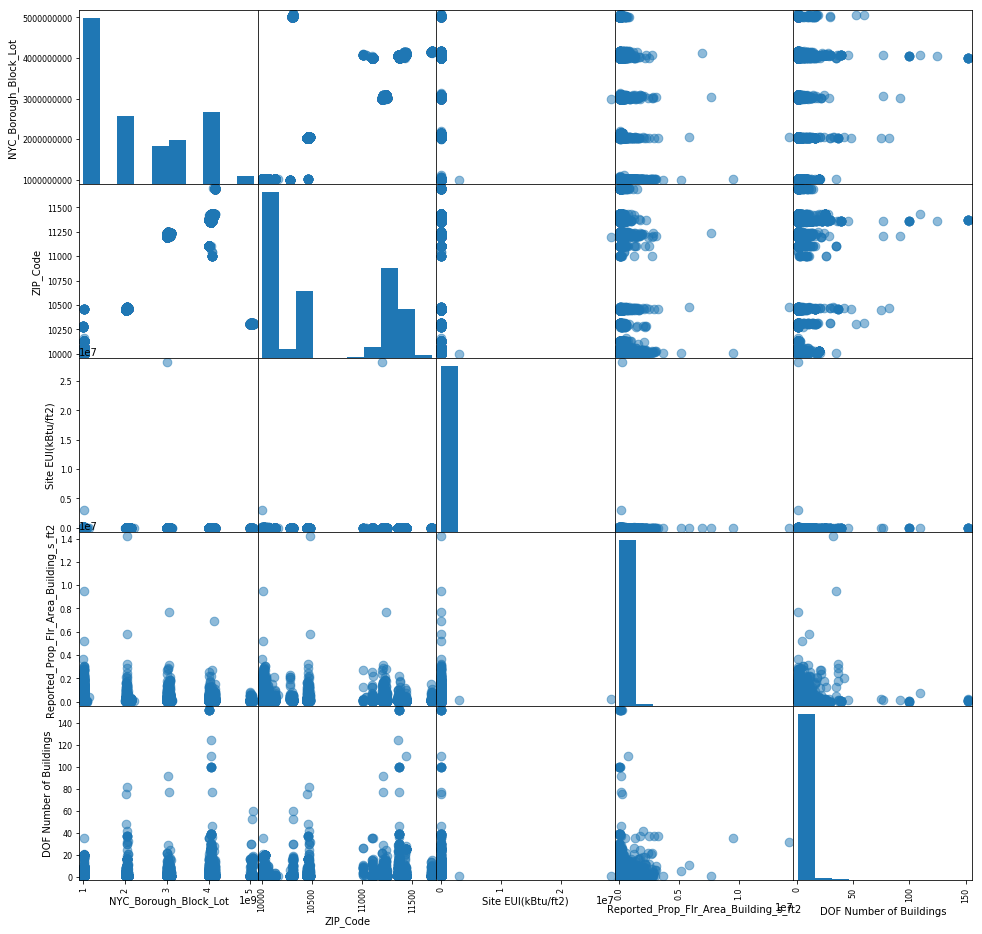

In [10]:
#try make a scatter plot of nrg. Few columns will plot - only those that have numerical values. 
#Pandas will ignore the other ones

from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16));
#pl.title("Figure 1: Scatter matrix of variables in Energy dataset \n", fontsize=20);


## Comment
**Figure 1: **Interesting positive relationships between NYC_Borough_Block_Lot and ZIP_Code, Reported_Prop_Flr_Are_Building and DOF Number of Buildings. NYC_BBL, ZIP_code are both classification variables, whereas Site EUI(kBtu/ft2), Reported_Prop_Flr_Area_Building_s_ft2, and DOF Number of Buildings an numerical variables




Numeric variables fixed above using  pd.to_numeric

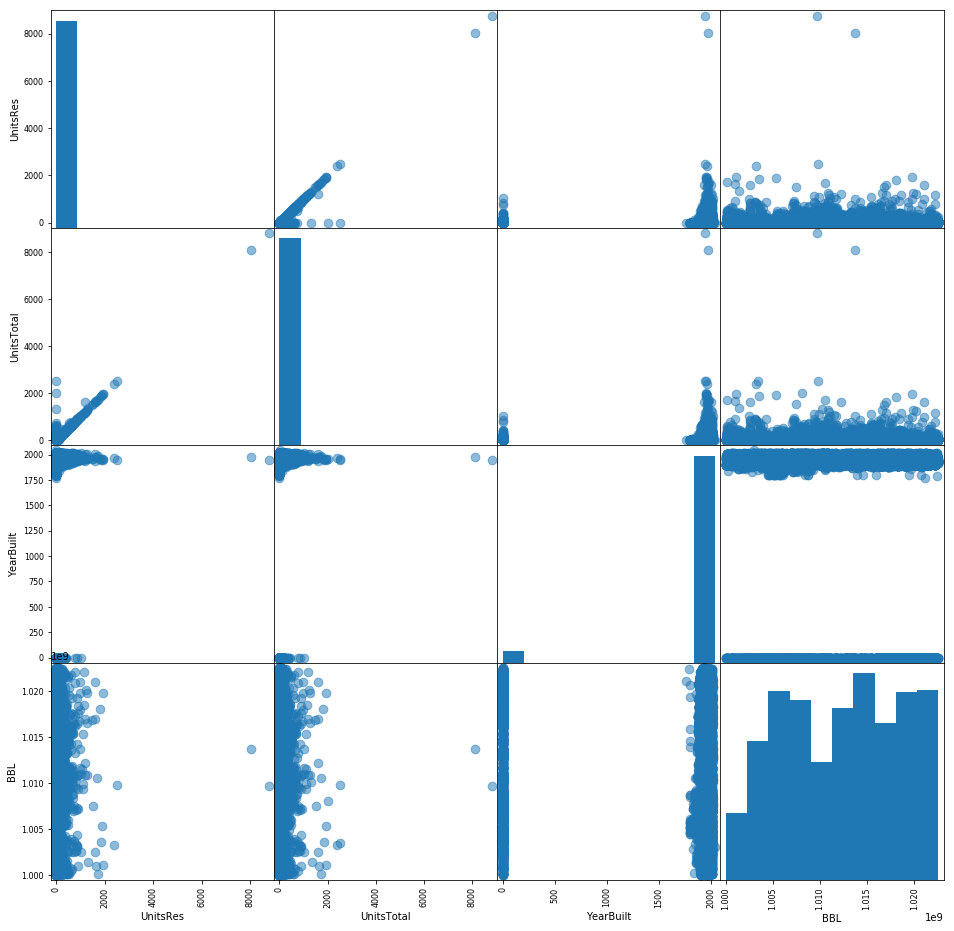

In [11]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix (bsize, s=300, figsize=(16, 16));


### Comment
**Figure 2:**  Strong positive relationship between UnitsRes and UnitsTotal. YearBuilt  has a group of very large variables (around 2000) and very small variables (clustered around 0). BBL is a classification variable. 

#### Merge on common index

Merging the two dataframe on the BBL (Borough, Block, Lot) identifier. Not in the Energy dataset, the column needs to be renamed which we do as a first step.

In [12]:
nrg.rename(columns={'NYC_Borough_Block_Lot' : 'BBL'}, inplace=True)

In [13]:
nrg.drop(['ZIP_Code', 'DOF Number of Buildings'], axis=1, inplace=True)

In [14]:
bblnrgdata = pd.merge(nrg, bsize, on='BBL').dropna()
bblnrgdata.shape

(5062, 6)

In [15]:
(bsize.BBL.values[0]), (nrg.BBL.values[0])

(1000010201.0, 1000410001.0)

In [16]:
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported_Prop_Flr_Area_Building_s_ft2,UnitsRes,UnitsTotal,YearBuilt
2,1.013110e+09,125.4,330000.0,0,56,1977
10,1.010140e+09,154.9,841709.0,0,2,1999
15,1.007660e+09,122.3,59468.0,0,8,1912
16,1.008150e+09,117.0,364000.0,0,24,1954
18,1.005050e+09,82.1,235370.0,0,24,1926


Our scatter matrix will now have more columns with the combined dataset.

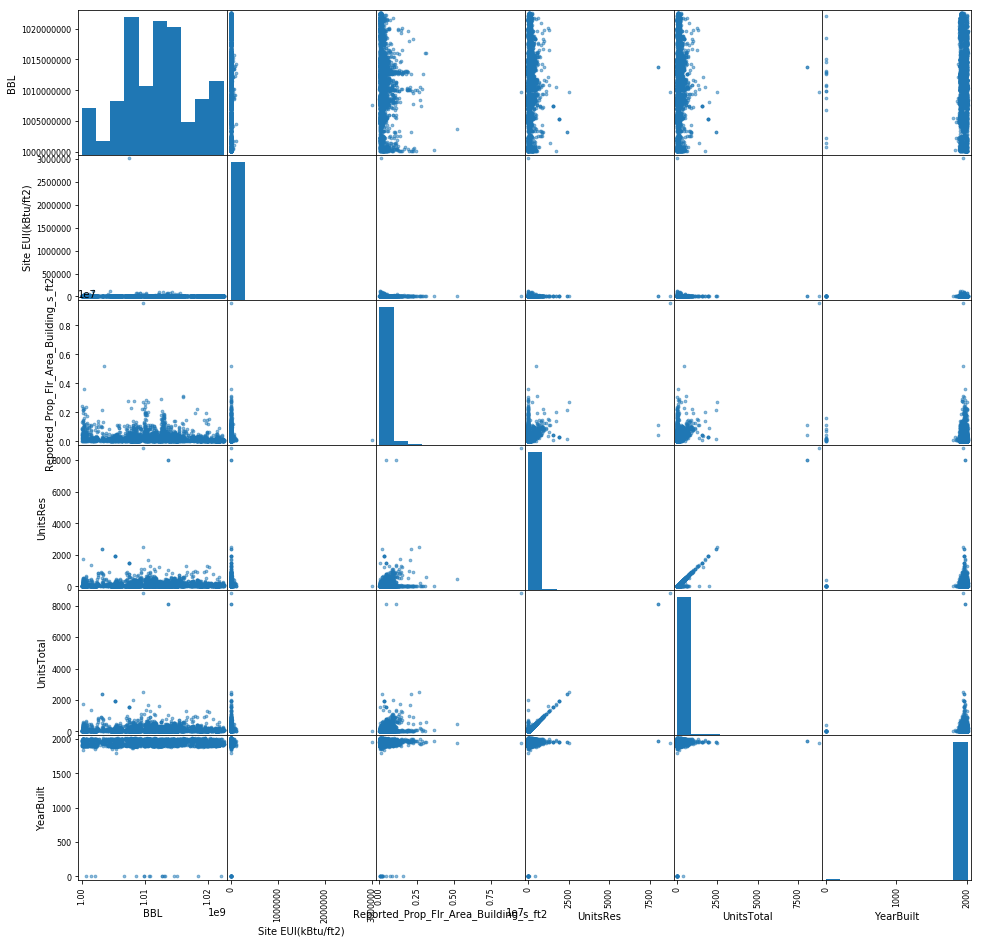

In [17]:

# Now the scatter matrix plot should show more columns.
scatter_matrix (bblnrgdata, s=30, figsize=(16, 16));

**Figure 3:** There appears to be a relationship between Reported Property Floor Area, UnitsTotal, UnitsRes, and Site EUI(kBtu/ft2). Year Built and BBL are classification variables.

Calculate EnergyTotal equal to 'Site EUI(kBtu/ft2)' x 'Reported_Prop_Flr_Area_Building_s_ft2'

In [18]:
bblnrgdata['EnergyTotal'] = bblnrgdata['Site EUI(kBtu/ft2)'] * bblnrgdata['Reported_Prop_Flr_Area_Building_s_ft2']

Plot 'Total energy consumption (kBtu)' against 'Number of units'

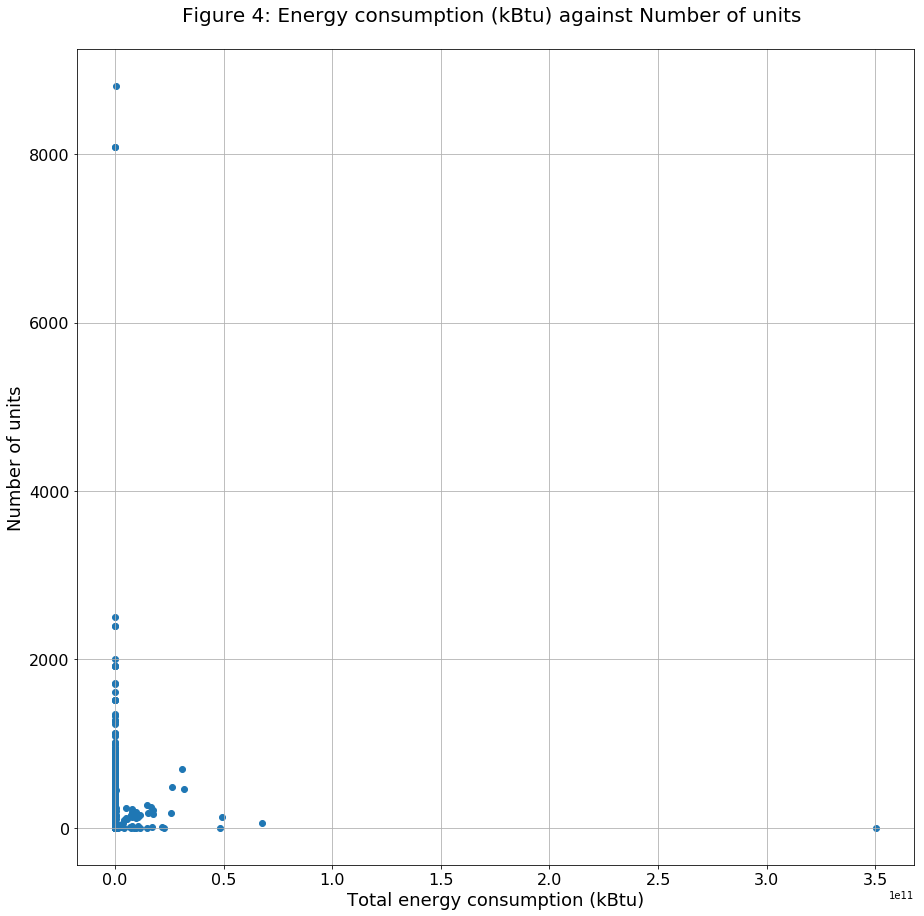

In [19]:
fig = pl.figure(figsize=(15,15)) 
ax = fig.add_subplot(111)

scatter = ax.scatter( bblnrgdata['EnergyTotal'], bblnrgdata['UnitsTotal'])

ax.tick_params(axis='both',labelsize=16)
pl.title("Figure 4: Energy consumption (kBtu) against Number of units \n", fontsize=20)
ax.set_ylabel("Number of units", fontsize=18)
ax.set_xlabel("Total energy consumption (kBtu)", fontsize=18)
ax.set_ylim()
ax.grid();

**Figure 4:** Initial plot of Energy consumption (kBtu) against Number of units. Note the scale needs to be updated to draw some of the meaningful insights.

Zoom in on more relevant areas with Number of units limited between o and 1,000; and Total energy consumption (kBtu) limited between 0 and 1e10.

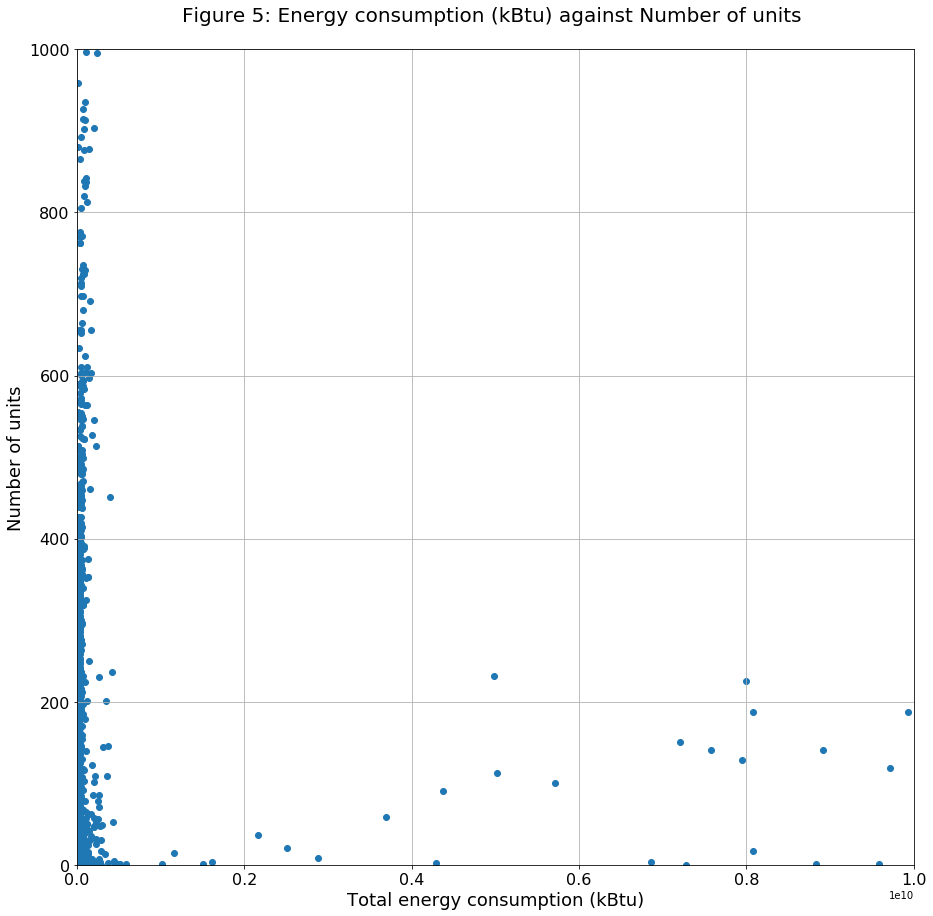

In [20]:
fig = pl.figure(figsize=(15,15)) 
ax = fig.add_subplot(111)

scatter = ax.scatter( bblnrgdata['EnergyTotal'], bblnrgdata['UnitsTotal'])

ax.tick_params(axis='both',labelsize=16)
pl.title("Figure 5: Energy consumption (kBtu) against Number of units \n", fontsize=20)
ax.set_ylabel("Number of units", fontsize=18)
ax.set_xlabel("Total energy consumption (kBtu)", fontsize=18)
ax.set_ylim(0,1e3)
ax.set_xlim(0,1e10)
ax.grid();

**Figure 5:** Plot of Energy consumption (kBtu) against Number of units. The values appear to be either very large, or very small. This is conducive to plotting on a log-scale. Lets first trim the dataset for smaller values of EnergyTotal, and UnitsTotal.

#### Cut dataset

Remove values where EnergyTotal is less than 1,000, UnitsTotal is less than  or equal to 10 and greater than 1,000, and plot on a log-log scale. 

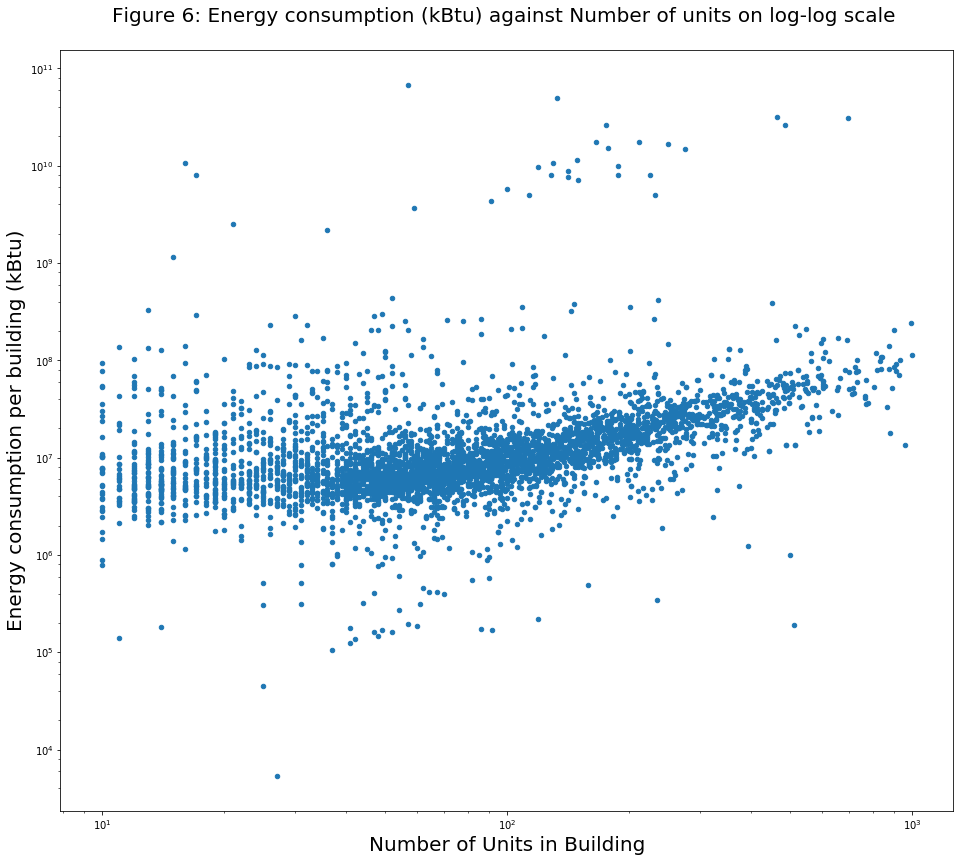

In [21]:


bblnrgdataCut = bblnrgdata[(bblnrgdata.EnergyTotal > 1000) & (bblnrgdata.UnitsTotal>=10) & 
                           (bblnrgdata.UnitsTotal<1000)]

ax = bblnrgdataCut.plot(kind='scatter', y='EnergyTotal', x='UnitsTotal', 
                   marker='o',  figsize=(16, 14), loglog=True)
yl = ax.set_xlabel("Number of Units in Building", fontsize=20)
xl = ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)
pl.title("Figure 6: Energy consumption (kBtu) against Number of units on log-log scale \n", fontsize=20);

**Figure 6:** The log-log scale has scaled the data appropriately to find positive (and possibly linear) relationship between Number of Units in Building and Energy consumption per building. Let's try fitting some models to this.

In [22]:
bblnrgdataCut.shape

(4266, 7)

#### Line fit ot the data
Remember to fit a line to the log of the variables as we are working in log-space:


In [23]:
y=bblnrgdataCut['EnergyTotal']
x=bblnrgdataCut['UnitsTotal']

X = sm.tools.add_constant(np.log10(x))
linmodel = sm.OLS(np.log10(y), X, missing='drop').fit() # ignores entires 
                                                     # where x or y is NaN
    


## Question: 
## Choose  which is your DEPENDENT and which is your INDEPENDENT variable. 
which is the "logical" IV: what are we assuming depends on what? energy on size of building or building on size of energy... discuss this but also test both fits, energy vs size and size vs energy. how can you compare these models? 


## Response:

The logical independent variable is Units, as the building/units should determine amount of energy usage. Let's fit both to determine best predictive power from models.



1. **Fit a line** to Units vs Energy. The independent variable in this problem should be number of units, but try fit both Unity to energy and energy to unit.
2. **Fit a line** to Energy vs Units.
3. **Evaluate which is better by calculating the chi square**.  Can you compare these models with the likelihood ratio test? (hint: are they nested??) I provide a function to calculate the chi square or you can write your own.

    The function is :
    
    chisq = $\sum_i \frac{(model(x_i) - data(x_i))^2 }{ error_i^2}$
    
    where the sum is over all datapoints, 
    
    for the i-th value  model($x_i$) is the prediction, data($x_i$) the observation,
    
    and $error_i$ is $\sqrt{data(x_i)}$
    (but remember you worked in log space! What are the proper errors?? see next point)
    
4. *Assume Poisson statistics* for the errors on the *independent variable*. Poisson statistics means your uncertainty is the square root of your measurement. I wrote down the formula for the errors. Please explain why I wrote it as I did.

5. **Fit a 2nd degree polynomial** to the Units vs Energy (with statsmodels.formulae.api.ols() for example passing the formula for a parabola, like we did in class. The formula for a 2nd deg polynomial is 
    $y = ax^2 + bx + c$ .

6. **Compare the Units vs Energy line fit and the Units vs Energy 2-nd degree polynomial fit with the Likelihood ratio test**. The formula is:
    
    LR  =  -2 * log(Likelihood_Model1 / Likelihood_Model2) 

    or equivalently
        
    LR  =  -2 * (logLikelihood_Model1 - logLikelihood_Model2) 
    
    where Model1 is the _least complex_ (fewer parameters).
    
    Th logLikelihood can be extracted from the model summary when using statsmodels. (Model1.llf)
    
    Compare this LR statistics to a chi sq table (for example http://passel.unl.edu/Image/Namuth-CovertDeana956176274/chi-sqaure%20distribution%20table.PNG) and say if *at alpha = 0.05* Model1 is preferable to Model2. The LR is chi^2 distributed with number of degrees of freedom $N_{DOF}$ = parameters_Model2 - parameters_Model1
    
    
    Also if you used statsmodels for the fit you can use the 
    compare_lr_test() method of your fit and verify you got the right answer.  Use the method compare_lr_test() of the most complex model of the 2 and pass it the result of stats models for the simpler fit 
    (e.g. smf.ols(formula = ...).fit().compare_lr_test(sm.OLS(...).fit()))



## Question 1:

**First plot:** fitting line to Units (IV) vs Energy (DV).

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            EnergyTotal   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     827.2
Date:                Sun, 26 Nov 2017   Prob (F-statistic):          2.05e-166
Time:                        15:33:37   Log-Likelihood:                -2563.5
No. Observations:                4266   AIC:                             5131.
Df Residuals:                    4264   BIC:                             5144.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.1110      0.033    187.012      0.000         6.047     6.175
UnitsTotal     0.4882      0.017     28.761      0.000         0.455     0.521
==============================================================================
Omnibus:                     2264.923   Durbin-Watson:                   1.668
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            44888.937
Skew:                           2.089   Prob(JB):                         0.00
Kurtosis:                      18.333   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

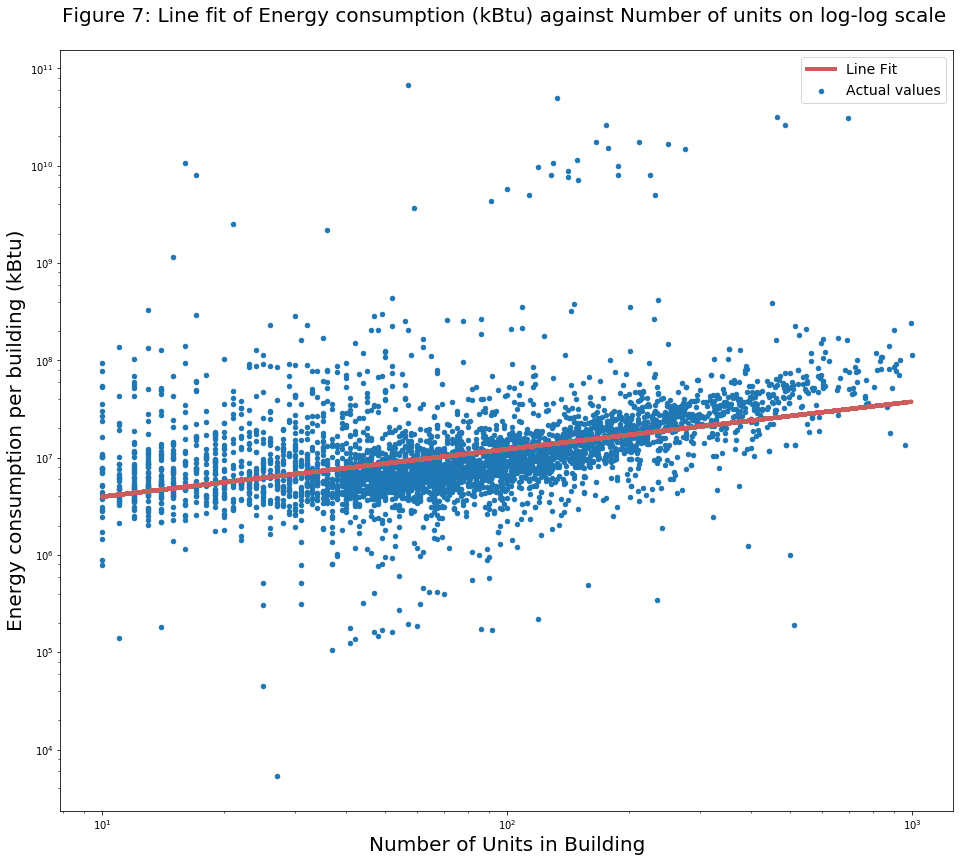

In [24]:
## PLOT 1: Units vs Energy




ax = bblnrgdataCut.plot(kind='scatter', y='EnergyTotal', x='UnitsTotal', 
                   marker='o',  figsize=(16, 14), loglog=True, label="Actual values")
xl = ax.set_xlabel("Number of Units in Building", fontsize=20)
yl = ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)

y=bblnrgdataCut['EnergyTotal']
x=bblnrgdataCut['UnitsTotal']

X = sm.tools.add_constant(np.log10(x))
linmodel = sm.OLS(np.log10(y), X, missing='drop').fit() # ignores entires 
                                                     # where x or y is NaN
plot()    


ax.plot(x, 10**linmodel.fittedvalues, color="IndianRed", label="Line Fit", linewidth=4.0)

    


plt.legend(fontsize=14);
pl.title("Figure 7: Line fit of Energy consumption (kBtu) against Number of units on log-log scale \n", fontsize=20);

linmodel.summary()

**Figure 7:** The log-log scale has scaled the data appropriately to find positive (and possibly linear) relationship between Number of Units in Building and Energy consumption per building. Let's try fitting some models to this.

## Question 4: explanation of calculation of errors (Poisson, propagated)

Errors in EnergyTotal are calculated as the square root of our measurement (in this case EnergyTotal); except that we calculated EnergyTotal using two other variables 'Site EUI(kBtu/ft2)' and 'Reported_Prop_Flr_Area_Building_s_ft2'. We assume these two variables are independent, and measurement subject to their own errors. The Error on EnergyTotal is the square root of the sum of the squares of each of these variables.

As we are working in logspace for our linear models, the errors need to be propagated and defined as the variable 'errorsInLogNrg'.



In [25]:
#Below I am writing out some uncertainties - please explain the functional form that I used.
#errors on the measured quantities
errorsnrg = np.sqrt((bblnrgdataCut['Reported_Prop_Flr_Area_Building_s_ft2'])**2 +\
                (bblnrgdataCut['Site EUI(kBtu/ft2)']**2))


errorsInLogNrg = np.abs(errorsnrg / bblnrgdataCut.EnergyTotal / np.log(10))


Calculate chi-square statistic using function defined below with relevant model, actual and error inputs

In [26]:
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.ones_like(data)
    if data.shape == model.shape and data.shape == errors.shape:
        return (((data - model)**2) / errors**2).sum()
    else: 
        print ('''ERROR:
must pass arrays of identical dimension for data, model and (optional) error)''')
    return -1

In [27]:
linmodelchi = chi2( np.log10(y), linmodel.fittedvalues, errorsInLogNrg)
print('The chi-square statistic for model EnergyTotal ~ UnitsTotal is {} '.format(linmodelchi))

The chi-square statistic for model EnergyTotal ~ UnitsTotal is 3.49306834927e+12 


## Question 3 (part i):

The chi-squared is very large suggesting there is still significant difference between the model fit and actual values (i.e. the model isn't necessarily a great fit). The R-squared is approx. 16% sugesting low explanatory power of the model.

## Question 2:

**Second plot:** fitting line to Energy (IV) vs. Units (DV) 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             UnitsTotal   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     827.2
Date:                Sun, 26 Nov 2017   Prob (F-statistic):          2.05e-166
Time:                        15:33:39   Log-Likelihood:                -1746.4
No. Observations:                4266   AIC:                             3497.
Df Residuals:                    4264   BIC:                             3510.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const          -0.4563      0.082     -5.596      0.000        -0.616    -0.296
EnergyTotal     0.3328      0.012     28.761      0.000         0.310     0.356
==============================================================================
Omnibus:                      149.498   Durbin-Watson:                   1.385
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              165.251
Skew:                          -0.464   Prob(JB):                     1.31e-36
Kurtosis:                       3.260   Cond. No.                         105.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

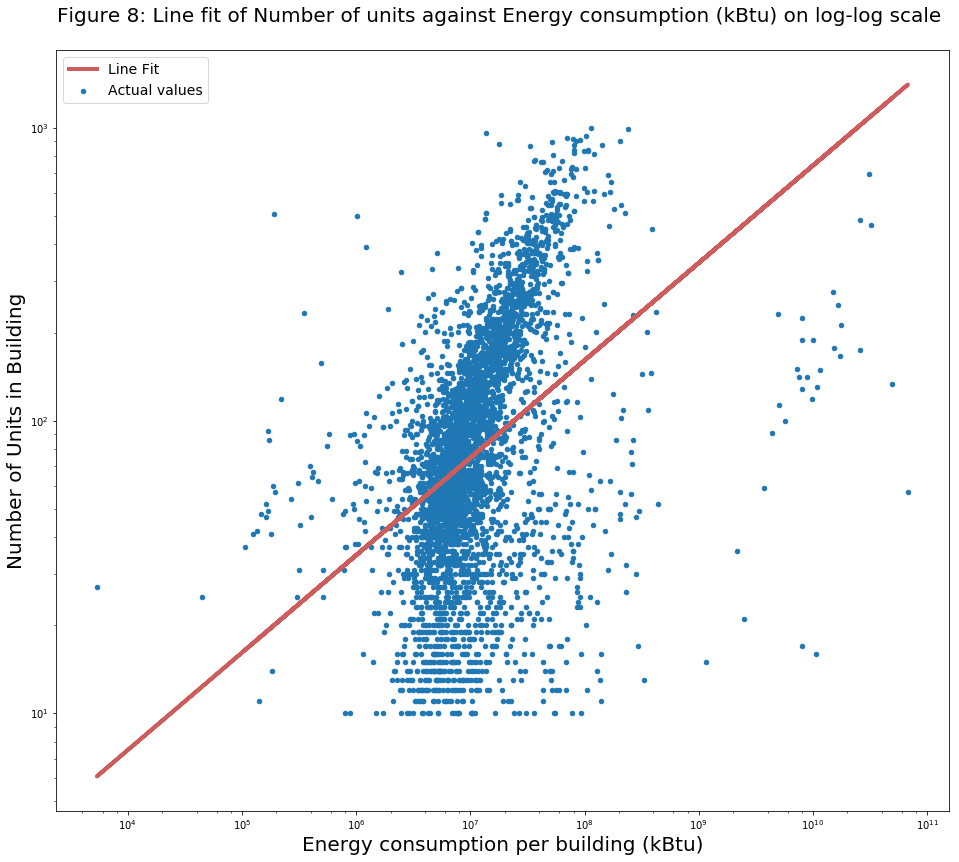

In [28]:
## PLOT 2: Energy vs Units


ax = bblnrgdataCut.plot(kind='scatter', x='EnergyTotal', y='UnitsTotal', 
                   marker='o',  figsize=(16, 14), loglog=True, label="Actual values")
ytwol = ax.set_ylabel("Number of Units in Building", fontsize=20)
xtwol = ax.set_xlabel("Energy consumption per building (kBtu)", fontsize=20)

xtwo = bblnrgdataCut['EnergyTotal']
ytwo = bblnrgdataCut['UnitsTotal']

Xtwo = sm.tools.add_constant(np.log10(xtwo))
linmodel2 = sm.OLS(np.log10(ytwo), Xtwo, missing='drop').fit() # ignores entires 
                                                         # where xtwo or ytwo is NaN
plot()    


ax.plot(xtwo, 10**linmodel2.fittedvalues, color="IndianRed", label="Line Fit", linewidth=4.0)
plt.legend(fontsize=14);
pl.title("Figure 8: Line fit of Number of units against Energy consumption (kBtu) on log-log scale \n", fontsize=20);

    
linmodel2.summary()


**Figure 8:** Line fit of Number of units in Building and Energy consumption (kBtu). R-square same between the line fits, although standard errors are smaller under this model.



In [29]:
errorsunits = np.sqrt(bblnrgdataCut.UnitsTotal)
errorsInLogUnits = np.abs(errorsunits / bblnrgdataCut.UnitsTotal / np.log(10))

In [30]:
linmodelchi = chi2( np.log10(ytwo), linmodel2.fittedvalues, errorsInLogUnits)
print('The chi-square statistic for model UnitsTotal ~ EnergyTotal is {} '.format(linmodelchi))

The chi-square statistic for model UnitsTotal ~ EnergyTotal is 485793.290042 


## Question 3 (part ii):

Note the chi-squared statistic is a lot better for this model, although it is impacted by the units of the y-variable in this case (being Number of units in the buildings). The models are not nested, and a comparison between the chi-squared statistics doesn't make sense for these two line fit comparisons. The null hypothesis is still rejected, and the model fit is significantly different from the actual values for the second linefit model.

In [31]:
nrg = bblnrgdataCut['EnergyTotal']
x = bblnrgdataCut['UnitsTotal']
#x2 = bblnrgdataCut['UnitsTotal'] * bblnrgdataCut['UnitsTotal']

#'Logy': np.log10(nrg),

dfquad = pd.DataFrame({'Logx': np.log10(x), 'Logx2' : np.log10(x) * np.log10(x) })

Xquad = sm.tools.add_constant(dfquad)


linmodel3 = sm.OLS(np.log10(nrg), Xquad , missing='drop').fit() # ignores entires 
                                                         # where xtwo or ytwo is NaN

linmodel3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            EnergyTotal   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     617.1
Date:                Sun, 26 Nov 2017   Prob (F-statistic):          4.37e-236
Time:                        15:33:40   Log-Likelihood:                -2399.4
No. Observations:                4266   AIC:                             4805.
Df Residuals:                    4263   BIC:                             4824.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          8.0824      0.111     72.620      0.000         7.864     8.301
Logx          -1.6820      0.119    -14.175      0.000        -1.915    -1.449
Logx2          0.5710      0.031     18.465      0.000         0.510     0.632
==============================================================================
Omnibus:                     2411.825   Durbin-Watson:                   1.721
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            59289.371
Skew:                           2.208   Prob(JB):                         0.00
Kurtosis:                      20.722   Cond. No.                         115.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Question 5: Quadratic fit 

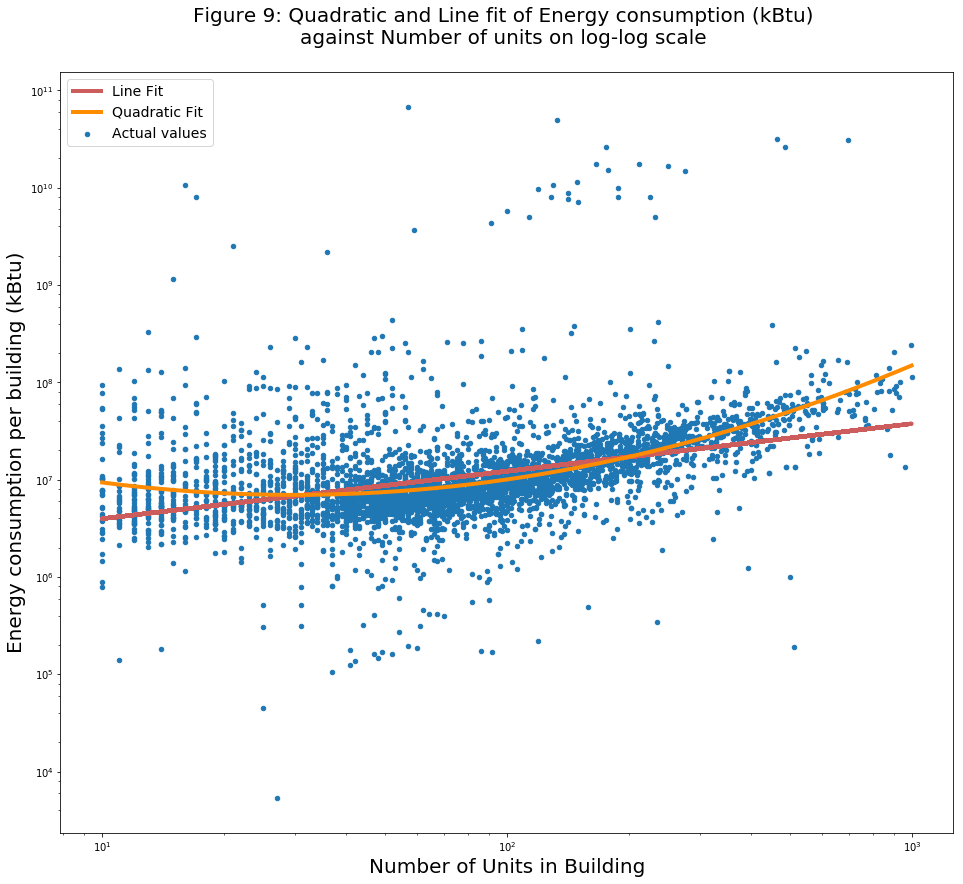

In [32]:
## PLOT 3: Units and Units^2 vs Energy


ax = bblnrgdataCut.plot(kind='scatter', y='EnergyTotal', x='UnitsTotal', 
                   marker='o',  figsize=(16, 14), loglog=True, label="Actual values")


a = np.linspace(min(x), max(x), 1000)


ax.plot(x, 10 ** linmodel.fittedvalues, color="IndianRed", linewidth=4.0, label="Line Fit")


ax.plot(a, 10 **  (linmodel3.params[0] +  linmodel3.params[1] * np.log10(a) + 
                   linmodel3.params[2] * (np.log10(a) **2)) , color="DarkOrange", linewidth=4.0 , label="Quadratic Fit")


xl = ax.set_xlabel("Number of Units in Building", fontsize=20)
yl = ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)
plt.legend(fontsize=14);
pl.title("Figure 9: Quadratic and Line fit of Energy consumption (kBtu) \nagainst Number of units on log-log scale \n", fontsize=20);



**Figure 9: ** Quadratic fit of Energy consumption (kBtu) against Number of units in Building provides a slightly better fit (R-square equal to 22.5%).


We'll now compare the Units vs Energy line fit and the Units vs Energy 2-nd degree polynomial fit with the Likelihood ratio test



## Question 6: Log-likelihood comparisons

In [33]:
print("The log-likelihood of the line fit model equals :  {}".format(round(linmodel.llf,4)))
print("The log-likelihood of the quadratic fit model equals :  {}".format(round(linmodel3.llf,4)))

print ("MANUALLY: Likelihood ratio test statistic calculated between two models : {}".format( round( 2 * (-linmodel.llf - (-linmodel3.llf)),4)))

llrComp = linmodel3.compare_lm_test(linmodel)

print ("Using the likelihood ratio test from statsmodels, the test statistic is {} with p-value {}".format(round(llrComp[0],4),round(llrComp[1],4)))


The log-likelihood of the line fit model equals :  -2563.511
The log-likelihood of the quadratic fit model equals :  -2399.3853
MANUALLY: Likelihood ratio test statistic calculated between two models : 328.2513
Using the likelihood ratio test from statsmodels, the test statistic is 315.9403 with p-value 0.0


We reject $H_0$ and conclude that there is a significant difference between the linear and quadratic model. The quadratic term does provide 'further' explanatory power.

## Extra credit 1: calculate and plot the likelihood surface
Create a function that minimizes the residuals:

the residuals are the sum of the differences between data and model: in the case of a line fit model. Use the same function you created for the chi^2 test.

You should sum over each datapoints the residuals squared, which should look something like

(np.log(bblnrgdatacut.nrg) - np.log(bblnrgdatacut.UnitsTotal)*a+b )^2 / errors^2

where a and b are the parameters returned by the line fitter. 

For each data point you can calculate the model at different values : for example in a range B = np.arange (-100, 100, 1) for the intercept, and A = np.arange(-50.0, 50.0, 0.5) for the slope.


You can write it as a nested for loop (or challenge yourself and vectorize it!) with a loop inside another ranging all poissible combinations of the 2 variables (i use enumerate to get both an index from 0 to the size of my array, which i assign to i (and j) and the value of the array at that index - look up the syntax!):


Lsurface = np.zeros((len(A), len(B)))
for i,a in enumerate(A):
    for j,b in enumerate(B):
         Lsurface[i][j] = np.nansum(residuals(a,b,data,errors)) .....

this gives you a 2D array that represents your likelihood surface! What we do to find a good fit is find the minimum (lowest point) on this surface.
You can plot a surface (a 2D array) with pl.imshow(Lsurface) as a "heatmap" but when you do that you will find that the plot is very uninformative. just like you did before with the data, plot the log of it (pl.imshow(np.log(Lsurface)). Also make sure your x and y axes tick numbers represent the range of values, not the cell index, which is the default for imshow. Inputting your data in the cell below should give a plot similar to mine

NameError: name 'Lsurface' is not defined

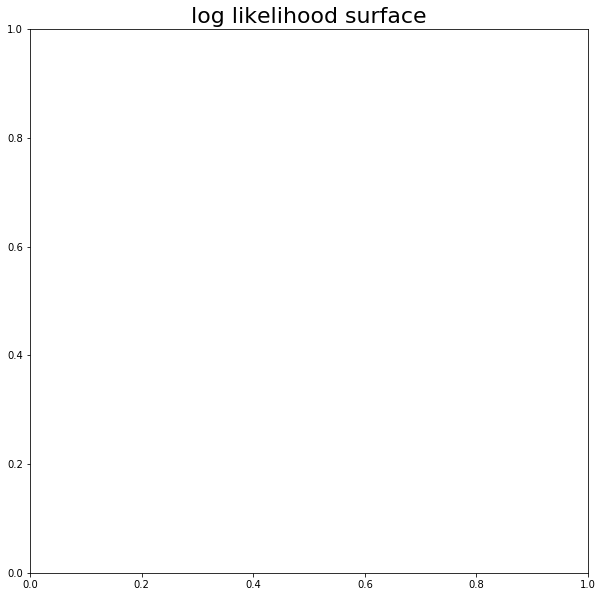

In [34]:
pl.figure(figsize=(10,10))
pl.title ("log likelihood surface", fontsize = 22)
pl.imshow(np.log(Lsurface), extent = [-50,50,100,-100], aspect=0.5)
pl.xlabel('slope', fontsize = 22)
pl.ylabel('intercept', fontsize = 22)
pl.colorbar()

## EXTRA CREDIT: get creative with the dataset. can you make an insigntful plot to show any structure in the data?

below I am mapping the building age to a colormap and the ratio of total to residential units to the size of the datapoint.

In [ ]:
bblnrgdata['YearBuilt'][bblnrgdata['YearBuilt']<1800]=1800

bblnrgdata.plot(kind='scatter',x='nrg',y='UnitsTotal', 
                fontsize=22, colormap='gist_rainbow', alpha = 1, 
                marker='o',  figsize=(16, 14), loglog=True,  
                xlim=(1000,1e11), ylim=(1,1000), 
                c=bblnrgdata['YearBuilt']-1900, 
                s=bblnrgdata['UnitsTotal']/bblnrgdata['UnitsRes']*100)
pl.title('Color maps Age in years, Size maps tital/residential units', fontsize=18)
pl.ylabel("total number of units", fontsize=22)
pl.xlabel("total energy consumption (kBtu)", fontsize=22)

## ASH - Score 100. Extra Credit Missing and has errors